In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss
# remove warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from tqdm import tqdm
import time
import copy
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
!pip install oulumetrics
import oulumetrics
!pip install keras
!pip install tensorflow-addons
!pip install gdown
import subprocess

  Preparing metadata (setup.py) ... - done
  Created wheel for oulumetrics: filename=oulumetrics-0.1-py3-none-any.whl size=2459 sha256=e5b158d7baab8da47b83ebb7a395d8863040e6fe3fb0b4d192aac75336bba965
  Stored in directory: /root/.cache/pip/wheels/7a/12/a3/9f8ea1ed198c858c48af6153e447a4c474f4f79c9b82abe104
Successfully built oulumetrics


# Dataset Extraction

In [2]:
protocol = 'Protocol1'
color_space = 'RGB'


In [3]:

!gdown --id 1EzhHs0C6UR3-CjN9SAtTUyGI3zRI0tAG


# specify the file name and destination directory
file_name = f'{protocol}_{color_space}_Seperated_undersampled'
# construct the command to unzip the file
command = ['unzip','-q', file_name]
# execute the command
subprocess.run(command)



/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1EzhHs0C6UR3-CjN9SAtTUyGI3zRI0tAG
From (redirected): https://drive.google.com/uc?id=1EzhHs0C6UR3-CjN9SAtTUyGI3zRI0tAG&confirm=t&uuid=f7ecfe66-b7da-42f7-8689-9682a5bfc4a8
To: /kaggle/working/Protocol1_RGB_Seperated_undersampled.zip
100%|█████████████████████████████████████████| 451M/451M [00:02<00:00, 172MB/s]


CompletedProcess(args=['unzip', '-q', 'Protocol1_RGB_Seperated_undersampled'], returncode=0)

# Dataset Loading

In [4]:
dataset_path = f"/kaggle/working/{file_name}"

In [5]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
#             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.20, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "dev/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(dev_loader, test_loader, dev_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [8]:
classes = get_classes(f"/kaggle/working/{file_name}/train/")
print(classes, len(classes))

['fake', 'true'] 2


In [9]:
dataloaders = {
    "train": train_loader,
    "val": dev_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": dev_data_len
}

In [10]:
print(len(train_loader), len(dev_loader), len(test_loader))

45 283 243


In [11]:
print(train_data_len, dev_data_len, test_data_len)

5663 9027 7758


In [12]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# model_names = timm.list_models(pretrained=True)
# print(model_names)

# Model Parameters

In [14]:
pretrained_model_name = 'deit_base_patch16_224'   #cait_M48 cait_XXS36_224 cait_S24_224 deit_base_distilled_patch16_224 deit_base_patch16_224 deit_tiny_distilled_patch16_224
no_epochs = 50

In [15]:

learning_rate = 0.03
model = torch.hub.load('facebookresearch/deit:main', pretrained_model_name, pretrained=True)

for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    
#     nn.BatchNorm1d(192),
#     nn.Linear(n_inputs, 512),
#     nn.ReLU(),
# #     nn.BatchNorm1d(512),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(128, 64),
#     nn.ReLU(),
# #     nn.Dropout(0.2, inplace=True),
    
#     nn.Linear(64, len(classes))
    ############################################
    nn.BatchNorm1d(768),
    nn.Linear(n_inputs, 512),
    nn.Mish(),
#     nn.BatchNorm1d(512),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(512, 256),
    nn.Mish(),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(256, 128),
    nn.Mish(),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(128, 64),
    nn.Mish(),
#     nn.Dropout(0.2, inplace=True),
    
    nn.Linear(64, len(classes))
    ##############################################
    
#     nn.BatchNorm1d(192),
# #     nn.Linear(n_inputs, 512),
#     nn.PReLU(),
# #     nn.BatchNorm1d(512),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(512, 256),
#     nn.PReLU(),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(256, 128),
#     nn.PReLU(),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(128, 64),
#     nn.PReLU(),
    #################################
#     nn.Linear(n_inputs, 512),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, len(classes))
)

# model.head = head_params
model = model.to(device)
# print(model)
# parameters


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [16]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.SGD(model.head.parameters(), lr=learning_rate, momentum=0.5)

In [17]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [18]:
train_accs = []
val_accs = []
train_losses = []
val_losses=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
#                     print(outputs)
                    _, preds = torch.max(outputs,1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu()
            if phase == 'val':
                val_accs.append(epoch_acc)
                val_losses.append(epoch_loss)
            else:
                train_accs.append(epoch_acc)
                train_losses.append(epoch_loss)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Train Acc: {:.4f}".format(max(train_accs)))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

# Model Training

In [19]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=no_epochs) 


Epoch 0/49
----------


100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


train Loss: 0.6931 Acc: 0.5151


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]


val Loss: 0.6985 Acc: 0.2651

Epoch 1/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.6875 Acc: 0.5547


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.6965 Acc: 0.3703

Epoch 2/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.6806 Acc: 0.6405


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.6893 Acc: 0.5513

Epoch 3/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.6636 Acc: 0.7081


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.6589 Acc: 0.7326

Epoch 4/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.6170 Acc: 0.7597


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]


val Loss: 0.5649 Acc: 0.8097

Epoch 5/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.5170 Acc: 0.8075


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.4718 Acc: 0.8362

Epoch 6/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.4456 Acc: 0.8425


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]


val Loss: 0.4206 Acc: 0.8664

Epoch 7/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.4000 Acc: 0.8773


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3909 Acc: 0.8870

Epoch 8/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.3713 Acc: 0.9011


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3798 Acc: 0.8979

Epoch 9/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.3491 Acc: 0.9172


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]


val Loss: 0.3848 Acc: 0.8920

Epoch 10/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.34it/s]


train Loss: 0.3368 Acc: 0.9271


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]


val Loss: 0.3736 Acc: 0.9050

Epoch 11/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.3307 Acc: 0.9315


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3696 Acc: 0.9037

Epoch 12/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.34it/s]


train Loss: 0.3225 Acc: 0.9359


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3618 Acc: 0.9091

Epoch 13/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.34it/s]


train Loss: 0.3104 Acc: 0.9447


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3593 Acc: 0.9131

Epoch 14/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.3075 Acc: 0.9513


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3649 Acc: 0.9076

Epoch 15/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.3044 Acc: 0.9509


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3662 Acc: 0.9074

Epoch 16/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.3028 Acc: 0.9504


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3461 Acc: 0.9216

Epoch 17/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.31it/s]


train Loss: 0.2969 Acc: 0.9551


100%|██████████| 283/283 [00:56<00:00,  5.03it/s]


val Loss: 0.3337 Acc: 0.9301

Epoch 18/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2955 Acc: 0.9574


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3366 Acc: 0.9287

Epoch 19/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2932 Acc: 0.9553


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3405 Acc: 0.9233

Epoch 20/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2879 Acc: 0.9615


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3449 Acc: 0.9242

Epoch 21/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2899 Acc: 0.9597


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3510 Acc: 0.9178

Epoch 22/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2839 Acc: 0.9656


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3270 Acc: 0.9318

Epoch 23/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.30it/s]


train Loss: 0.2848 Acc: 0.9606


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3289 Acc: 0.9291

Epoch 24/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2805 Acc: 0.9666


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3458 Acc: 0.9213

Epoch 25/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2825 Acc: 0.9666


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3296 Acc: 0.9328

Epoch 26/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2800 Acc: 0.9675


100%|██████████| 283/283 [00:55<00:00,  5.05it/s]


val Loss: 0.3320 Acc: 0.9309

Epoch 27/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.2745 Acc: 0.9712


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3272 Acc: 0.9334

Epoch 28/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.2762 Acc: 0.9672


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3257 Acc: 0.9344

Epoch 29/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2741 Acc: 0.9695


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3289 Acc: 0.9310

Epoch 30/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2764 Acc: 0.9686


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]


val Loss: 0.3404 Acc: 0.9235

Epoch 31/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2757 Acc: 0.9689


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3253 Acc: 0.9343

Epoch 32/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2734 Acc: 0.9709


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3280 Acc: 0.9320

Epoch 33/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.2722 Acc: 0.9698


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3256 Acc: 0.9345

Epoch 34/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.2703 Acc: 0.9726


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3260 Acc: 0.9344

Epoch 35/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2673 Acc: 0.9763


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3231 Acc: 0.9354

Epoch 36/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.2665 Acc: 0.9755


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3230 Acc: 0.9336

Epoch 37/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2671 Acc: 0.9733


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3148 Acc: 0.9374

Epoch 38/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2667 Acc: 0.9732


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3198 Acc: 0.9366

Epoch 39/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.2649 Acc: 0.9735


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3127 Acc: 0.9402

Epoch 40/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.32it/s]


train Loss: 0.2659 Acc: 0.9751


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3214 Acc: 0.9353

Epoch 41/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2625 Acc: 0.9765


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3183 Acc: 0.9383

Epoch 42/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.34it/s]


train Loss: 0.2602 Acc: 0.9781


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


val Loss: 0.3151 Acc: 0.9400

Epoch 43/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.2597 Acc: 0.9792


100%|██████████| 283/283 [00:56<00:00,  5.03it/s]


val Loss: 0.3167 Acc: 0.9370

Epoch 44/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2594 Acc: 0.9783


100%|██████████| 283/283 [00:55<00:00,  5.05it/s]


val Loss: 0.3093 Acc: 0.9431

Epoch 45/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2554 Acc: 0.9804


100%|██████████| 283/283 [00:56<00:00,  5.03it/s]


val Loss: 0.3192 Acc: 0.9350

Epoch 46/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2560 Acc: 0.9788


100%|██████████| 283/283 [00:56<00:00,  5.03it/s]


val Loss: 0.3183 Acc: 0.9364

Epoch 47/49
----------


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


train Loss: 0.2575 Acc: 0.9799


100%|██████████| 283/283 [00:56<00:00,  5.04it/s]


val Loss: 0.3134 Acc: 0.9392

Epoch 48/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


train Loss: 0.2542 Acc: 0.9809


100%|██████████| 283/283 [00:55<00:00,  5.06it/s]


val Loss: 0.3136 Acc: 0.9403

Epoch 49/49
----------


100%|██████████| 45/45 [00:34<00:00,  1.31it/s]


train Loss: 0.2543 Acc: 0.9804


100%|██████████| 283/283 [00:55<00:00,  5.07it/s]

val Loss: 0.3099 Acc: 0.9403

Training complete in 75m 4s
Best Train Acc: 0.9809
Best Val Acc: 0.9431


In [20]:

# save the model
torch.save(model_ft.state_dict(), "Deit_Model.pth")


# Graphs

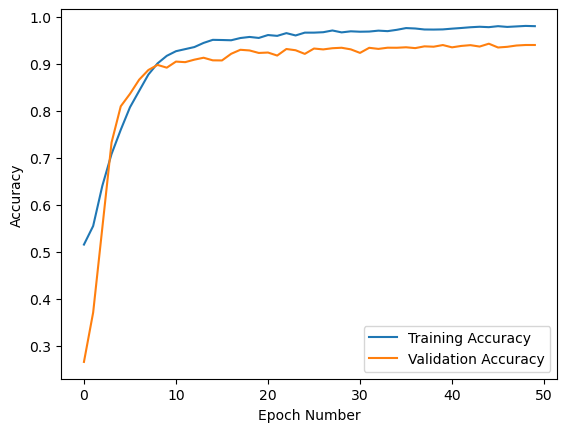

In [21]:
x = [i for i in range(no_epochs)]
# plot lines
plt.plot(x, train_accs, label = "Training Accuracy")
plt.plot(x, val_accs, label = "Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

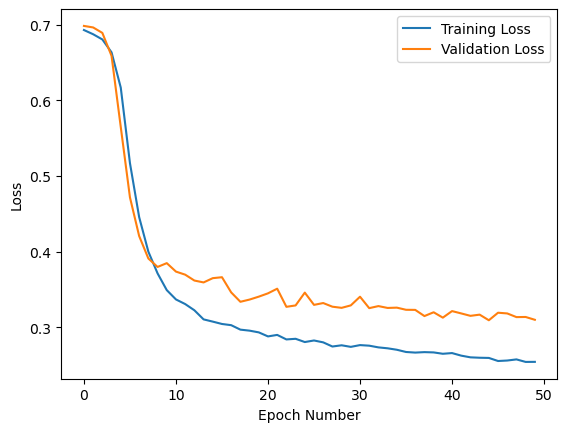

In [22]:
x = [i for i in range(no_epochs)]
# plot lines
plt.plot(x, train_losses, label = "Training Loss")
plt.plot(x, val_losses, label = "Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test and Dev Accuracies

In [23]:
dev_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
dev_predictions = []
dev_targets = []

for data, target in tqdm(dev_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    dev_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    pred_list = np.squeeze(pred.cpu().numpy())
    target_list = np.squeeze(target.cpu().numpy())
    dev_predictions.extend(pred_list)
    dev_targets.extend(target_list)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
#     print('target',target)
#     print('##################################################')
#     print('output',output)
#     print('##################################################')
#     print('pred',pred)
#     print('##################################################')
#     print('correct_tensor',correct_tensor)
#     print('##################################################')
#     print('correct',correct)
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print('class_correct',class_correct)
# print('##################################################')
# print('class_total',class_total)

dev_loss = dev_loss / dev_data_len
print('Dev Loss: {:.4f}'.format(dev_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Dev Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Dev accuracy of %5s: NA" % (classes[i]))
print("Dev Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 283/283 [00:56<00:00,  5.03it/s]

Dev Loss: 0.0001
Dev Accuracy of  fake: 95% (6641/6930)
Dev Accuracy of  true: 89% (1870/2094)
Dev Accuracy of 94% (8511/9024)


In [24]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
test_predictions = []
test_targets = []

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    pred_list = np.squeeze(pred.cpu().numpy())
    target_list = np.squeeze(target.cpu().numpy())
    test_predictions.extend(pred_list)
    test_targets.extend(target_list)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
#     print('target',target)
#     print('##################################################')
#     print('output',output)
#     print('##################################################')
#     print('pred',pred)
#     print('##################################################')
#     print('correct_tensor',correct_tensor)
#     print('##################################################')
#     print('correct',correct)
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print('class_correct',class_correct)
# print('##################################################')
# print('class_total',class_total)

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))



100%|██████████| 243/243 [00:48<00:00,  5.02it/s]

Test Loss: 0.0011
Test Accuracy of  fake: 84% (5193/6168)
Test Accuracy of  true: 84% (1336/1576)
Test Accuracy of 84% (6529/7744)


# Save the model

In [25]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("vit_model.pt")

In [26]:
# print('Target Labels: ',len(targets))
# print('Prediction Labels: ',len(predictions))

# Other Metrics

In [27]:
#EER
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
   
    return eer

test_EER = compute_eer(test_targets,test_predictions)
dev_EER = compute_eer(dev_targets,dev_predictions)

print('The EER for Dev is: {:.2f}'.format(dev_EER*100))
print('The EER for Test is: {:.2f}'.format(test_EER*100))

The EER for Dev is: 7.44
The EER for Test is: 15.54


In [28]:
#HTER
def calculate_HTER(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    far = fp / (fp + tn)
    frr = fn / (tp + fn)
    hter = (far + frr) / 2
    return hter

dev_hter = calculate_HTER(dev_targets, dev_predictions)
print('The HTER for Dev is: {:.2f}'.format(dev_hter*100))

test_hter = calculate_HTER(test_targets, test_predictions)
print('The HTER for Test is: {:.2f}'.format(test_hter*100))



The HTER for Dev is: 7.44
The HTER for Test is: 15.54


In [29]:
#APCER, BPCER, ACER
test_attack_types = [ (1 if x==1 else 2) for x in test_targets]
dev_attack_types = [ (1 if x==1 else 2) for x in dev_targets]


# returns the metrics APCER, BPCER and ACER
test_apcer, test_bpcer, test_acer = oulumetrics.calculate_metrics(test_attack_types, test_predictions)
dev_apcer, dev_bpcer, dev_acer = oulumetrics.calculate_metrics(dev_attack_types, dev_predictions)

print('######## Dev Oulu Metrics ##########')
print('APCER: {:.2f}'.format(dev_apcer*100))
print('BPCER: {:.2f}'.format(dev_bpcer*100))
print('ACER: {:.2f}'.format(dev_acer*100))

print('######## Test Oulu Metrics ##########')
print('APCER: {:.2f}'.format(test_apcer*100))
print('BPCER: {:.2f}'.format(test_bpcer*100))
print('ACER: {:.2f}'.format(test_acer*100))





######## Dev Oulu Metrics ##########
APCER: 4.18
BPCER: 10.69
ACER: 7.44
######## Test Oulu Metrics ##########
APCER: 15.81
BPCER: 15.26
ACER: 15.54


In [30]:
# Compute confusion matrix
cm = confusion_matrix(test_targets, test_predictions)
print("Confusion Matrix:")
print(cm)

# Compute F1 score
f1 = f1_score(test_targets, test_predictions)
print("F1 Score:", f1)

Confusion Matrix:
[[5202  977]
 [ 241 1338]]
F1 Score: 0.6872110939907549


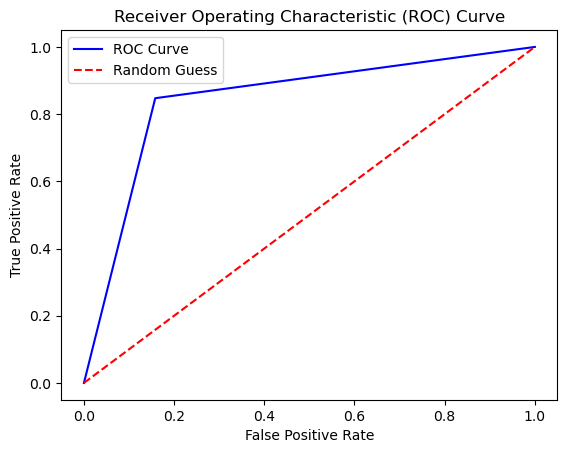

In [31]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_targets, test_predictions)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# # Add predicted labels to plot
# for i, threshold in enumerate(thresholds):
#     plt.annotate(threshold, (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

# for i, label in enumerate(test_predictions):
#     if label == 1:
#         plt.plot(fpr[i], tpr[i], 'o', color='green')
#     else:
#         plt.plot(fpr[i], tpr[i], 'o', color='red')

# plt.show()
